In [49]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [50]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [51]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.000000000000006)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 210]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710475410684)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 201]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00023661536974689252

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963744097293 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168266)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 225]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.1224892795338588), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920233658)
Current ansatz: [244, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.999999999952205)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 216]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.1231056252069065
(change of -0.12310562527738877)
Current ansatz: [228, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917518430081312
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485066714324805)]
Initial energy: -6.1231056252069065
Optimizing energy with indices [228, 79, 216, 225]...
Starting point: [np.float64(-0.7853879048615375), np.float64(0.7853901599313474), np.float64(-0.12248816317024809), np.float64(0.0)]

Current energy: -6.327276154818593
(change of -0.20417052961168647)
Current ansatz: [228, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964791886525
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.089491649572314)]
Initial energy: -6.327276154818593
Optimizing energy with indices [228, 79, 216, 225, 156]...
Starting point: [np.float64(-0.78539816296

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894919825745366)]
Initial energy: -6.327276154820074
Optimizing energy with indices [244, 79, 225, 147, 210]...
Starting point: [np.float64(0.7853981479801436), np.float64(0.7853981834326691), np.float64(-0.16357026296685157), np.float64(-0.16356988342672032), np.float64(0.0)]

Current energy: -6.464101615050255
(change of -0.13682546023018016)
Current ansatz: [244, 79, 225, 147, 210]
Performing final convergence check...
Total gradient norm: 0.0001482896166931572

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963655680355 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 57]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072774
(change of -0.13682546025278697)
Current ansatz: [244, 79, 228, 210, 57]
Performing final convergence check...
Total gradient norm: 0.000135056081442826

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047428929)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 198]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.12248927934333585), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819712
(change of -0.2041705292020648)
Current ansatz: [241, 31, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053182
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.089492926734877)]
Initial energy: -6.327276154819712
Optimizing energy with indices [241, 31, 228, 198, 45]...
Starting point: [np.float64(-0.7853981510104416), np.float64(-0.785398174208182), np.float64(0.163570197408367), np.float64(-0.16356963668287464), np.float64(0.0)]

Current energy: -6.464101614754331
(change of -0.13682545993461925)
Current ansatz: [241, 31, 228, 198, 45]
Performing final convergence check...
Total gradient norm: 0.00026578794938720884

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096258053182 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548199705
(change of -0.2041705292023277)
Current ansatz: [241, 74, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056871159
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916302649005)]
Initial energy: -6.3272761548199705
Optimizing energy with indices [241, 74, 228, 135, 147]...
Starting point: [np.float64(-0.7853981609143154), np.float64(-0.7853981725948302), np.float64(0.16357028742953827), np.float64(0.16356997549807345), np.float64(0.0)]

Current energy: -6.4641016150726855
(change of -0.13682546025271503)
Current ansatz: [241, 74, 228, 135, 147]
Performing final convergence check...
Total gradient norm: 0.0001350860626869118

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964056871159 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917558862786551
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485089250517599)]
Initial energy: -6.123105625381216
Optimizing energy with indices [228, 79, 198, 228]...
Starting point: [np.float64(-0.785396839867768), np.float64(0.7853935973592212), np.float64(-0.12249397020408477), np.float64(0.0)]

Current energy: -6.327276154736129
(change of -0.2041705293549132)
Current ansatz: [228, 79, 198, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625843350325
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.089492926704719)]
Initial energy: -6.327276154736129
Optimizing energy with indices [228, 79, 198, 228, 216]...
Starting point: [np.float64(-0.7853968398677638), np.float64(0.7853931643806783), np.float64(-0.16357019810105708), np.float64(0.16356963687457757), np.float64(0.0)]

Current energy: -6.464101615053796
(change of -0.13682546031766663)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 225]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610644
(change of -0.12310562561245586)
Current ansatz: [225, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955813
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850687898689876)]
Initial energy: -6.123105625610644
Optimizing energy with indices [225, 79, 225, 135]...
Starting point: [np.float64(0.7853983869831812), np.float64(0.7853991695302517), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474282707)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 210]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927934316764), np.float64(0.0)]

Current energy: -6.327276154819707
(change of -0.20417052920207546)
Current ansatz: [244, 26, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531786
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894929267348785)]
Initial energy: -6.327276154819707
Optimizing energy with indices [244, 26, 225, 210, 57]...
Starting point: [np.float64(0.7853981624018849), np.float64(0.78539816264672), np.float64(-0.16357019740836645), np.float64(0.16356963668287344), np.float64(0.0)]

Current energy: -6.4641016151347985
(change of -0.1368254603150918)
Current ansatz:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682814)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 210]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224892796166995), np.float64(0.0)]

Current energy: -6.327276154765011
(change of -0.20417052920252932)
Current ansatz: [228, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069117
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089491643863324)]
Initial energy: -6.327276154765011
Optimizing energy with indices [228, 79, 228, 210, 147]...
Starting point: [np.float64(-0.78539470657713), np.float64(0.7853982468601272), np.float64(0.16357028648716854), np.float64(0.16356997194353076), np.float64(0.0)]

Current energy: -6.464101615018027
(change of -0.13682546025301612)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001361285843518749

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850687898689596)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 147]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.12248869758311001), np.float64(0.0)]

Current energy: -6.32727615481636
(change of -0.20417052920571344)
Current ansatz: [225, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962567144736
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929485636227)]
Initial energy: -6.32727615481636
Optimizing energy with indices [225, 79, 228, 147, 210]...
Starting point: [np.float64(0.785398438850203), np.float64(0.7853991591701985), np.float64(0.16357019849079582), np.float64(-0.1635696317029856), np.float64(0.0)]

Current energy: -6.4641016151321224
(change of -0.13682546031576237)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200768378
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485071048168265)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 31, 201, 228]...
Starting point: [np.float64(-0.7853981633974474), np.float64(-0.7853981633974486), np.float64(0.12248927953385899), np.float64(0.0)]

Current energy: -6.327276154819971
(change of -0.20417052920232948)
Current ansatz: [241, 31, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381366
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.089491643867191)]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 31, 201, 228, 216]...
Starting point: [np.float64(-0.7853981633974672), np.float64(-0.7853981633977063), np.float64(0.16357028648501637), np.float64(0.1635699719432868), np.float64(0.0)]

Current energy: -6.464101615072812
(change of -0.13682546025284026)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850710474288458)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 108]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819719
(change of -0.20417052920207723)
Current ansatz: [241, 79, 228, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531777
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.0894929267349225)]
Initial energy: -6.327276154819719
Optimizing energy with indices [241, 79, 228, 108, 120]...
Starting point: [np.float64(-0.7853981614493319), np.float64(0.785398166202816), np.float64(0.16357019740836895), np.float64(-0.1635696366828649), np.float64(0.0)]

Current energy: -6.464101615132459
(change of -0.1368254603127399)
Current ansatz: [241, 79, 228, 108, 120]
Performing final convergence check...
Total gradient norm: 3.478938918747588e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531777 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894919825745366)]
Initial energy: -6.327276154820074
Optimizing energy with indices [244, 79, 225, 147, 210]...
Starting point: [np.float64(0.7853981479801436), np.float64(0.7853981834326691), np.float64(-0.16357026296685157), np.float64(-0.16356988342672032), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615050255
(change of -0.13682546023018016)
Current ansatz: [244, 79, 225, 147, 210]
Performing final convergence check...
Total gradient norm: 0.0001482896166931572

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963655680355 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001435936303541698

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481682663)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 201]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 108]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819705
(change of -0.2041705292020657)
Current ansatz: [244, 79, 228, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531789
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734879)]
Initial energy: -6.327276154819705
Optimizing energy with indices [244, 79, 228, 108, 210]...
Starting point: [np.float64(0.7853981655442128), np.float64(0.7853981656707975), np.float64(0.1635701974083666), np.float64(-0.16356963668287375), np.float64(0.0)]

Current energy: -6.464101615124094
(change of -0.13682546030438925)
Current ansatz: [244, 79, 228, 108, 210]
Performing final convergence check...
Total gradient norm: 5.187599764428612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531789 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999999993725)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 216]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625475226
(change of -0.12310562547703796)
Current ansatz: [225, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526155297296
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.48507102185107)]
Initial energy: -6.123105625475226
Optimizing energy with indices [225, 79, 216, 225]...
Starting point: [np.float64(0.7854038546599069), np.float64(0.7854037259371959), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154553884
(change of -0.20417052907865774)
Current ansatz: [225, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24098801236697
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089491894997419)]
Initial energy: -6.327276154553884
Optimizing energy with indices [225, 79, 216, 225, 201]...
Starting point: [np.float64(0.7853981604388534), np.float64(0.7853981095761736), np.float64(-0.16357577727298617), np.float64(-0.1635714425234246), np.float64(0.0)]

Current energy: -6.464101615061052
(change of -0.13682546050716837)
Current ansatz: [225, 79, 216, 225, 201]
Performing final convergence check...
Total gradient norm: 0.00014295796399436101

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24098801236697 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474292033)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 135]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819991
(change of -0.20417052920235168)
Current ansatz: [244, 79, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240964041381248
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916438672313)]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 79, 228, 135, 108]...
Starting point: [np.float64(0.7853981553846432), np.float64(0.7853981604652992), np.float64(0.16357028648499042), np.float64(0.16356997194327144), np.float64(0.0)]

Current energy: -6.4641016150556565
(change of -0.13682546023566555)
Current ansatz: [244, 79, 228, 135, 108]
Performing final convergence check...
Total gradient norm: 0.000146183677139128

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381248 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.000000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 225]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562494
(change of -0.12310562563297633)
Current ansatz: [228, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 210]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763838)
Current ansatz: [244, 79, 201]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768387
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.4850710481682685)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 79, 201, 228]...
Starting point: [np.float64(0.7853981633974513), np.float64(0.7853981633974504), np.float64(0.1224892795338593), np.float64(0.0)]

Current energy: -6.327276154819984
(change of -0.20417052920233658)
Current ansatz: [244, 79, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381381
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0894916438671975)]
Initial energy: -6.327276154819984
Optimizing energy with indices [244, 79, 201, 228, 216]...
Starting point: [np.float64(0.785398163397418

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013515787565729383

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 79]...
Starting point: [np.float64(-0.5535743588970451), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 228]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562482
(change of -0.1231056256329639)
Current ansatz: [228, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710484682814)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 135]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.122

## Run ADAPT at larger size to get a sequence of circuits.

In [52]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [53]:
# Now go to the larger size.
new_l = 8 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = tiled_pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 32
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -5.59893e+01-4.87721e-13j
Tiled pool has 499 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -31.000000000000554
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000172
Operator 1: 4.00000000000022
Operator 2: -4.000000000000155
Operator 3: 4.000000000000129
Operator 4: -4.000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -33.485281
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 23

Current energy: -33.48528137423912
(change of -0.8284271247462485)
Current ansatz: [497, 493, 487]
coefficients: [np.float64(0.3926990988785292), np.float64(0.392699081875618), np.float64(0.39269908170008233)]
indices: [497, 493, 487]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000172
Operator 1: 4.0000000000002185
Operator 2: -4.0000000000001545
Operator 3: 4.000000000000127
Operator 4: -4.000000000000146
Operator 5: 4.000000000000123
Operator 6: -4.000000000000095
Operator 7: 4.000000000000122
Operator 8: -4.000000000000118
Operator 9: 4.000000000000118
Operator 10: -4.000000000000112
Operator 11: 4.000000000000052
Operator 12: -4.000000000000054
Operator 13: 4.000000000000078
Operator 14: -3.414213562369296
Operator 16

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -34.420152
         Iterations: 6
         Function evaluations: 65
         Gradient evaluations: 53

Current energy: -34.42015207804764
(change of -0.9348707038085209)
Current ansatz: [497, 493, 487, 489]
coefficients: [np.float64(0.3926990896787873), np.float64(0.39269908178170293), np.float64(0.44314368978877194), np.float64(0.4431436581638791)]
indices: [497, 493, 487, 489]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000183
Operator 1: 4.00000000000023
Operator 2: -4.000000000000167
Operator 3: 4.0000000000001386
Operator 4: -4.000000000000157
Operator 5: 4.000000000000135
Operator 6: -4.000000000000106
Operator 7: 4.000000000000134
Operator 8: -4.000000000000131
Operator 9: 4.000000000000131
Operator 10: -4.0000000000001235
Operator 11: 4.000000000000065
Operator 12: -4.000000000000067
Operator 13: 4.000000000000092


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -37.011877
         Iterations: 7
         Function evaluations: 75
         Gradient evaluations: 60

Current energy: -37.011877031348405
(change of -0.9348707038087483)
Current ansatz: [497, 493, 487, 489, 483, 477, 479]
coefficients: [np.float64(0.3926990818246681), np.float64(0.39269908268118126), np.float64(0.44314362613192054), np.float64(0.4431436654781156), np.float64(0.3926990814187209), np.float64(0.44314363742221996), np.float64(0.4431436434262285)]
indices: [497, 493, 487, 489, 483, 477, 479]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000173
Operator 1: 4.000000000000216
Operator 2: -4.000000000000152
Operator 3: 4.000000000000125
Operator 4: -3.2645854715288793
Operator 5: 8.065672070241044e-08
Operator 6: -2.529170924451638
Operator 8: -3.264585452922923
Operator 9: 4.000000000000118
Operator 10: -3.41421356

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -38.915894
         Iterations: 5
         Function evaluations: 47
         Gradient evaluations: 41

Current energy: -38.91589447134638
(change of -1.0755903152517448)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408]
coefficients: [np.float64(0.4608980858834215), np.float64(0.4608980670526575), np.float64(0.4431436483059546), np.float64(0.44314364326737654), np.float64(0.3926990839596838), np.float64(0.443143644295075), np.float64(0.44314364357040453), np.float64(0.39269907319384945), np.float64(-0.5135774907526773)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135864286396
Operator 1: 9.62217330738285e-08
Operator 2: -3.4142135864286254
Operator 3: 4.0000000000001
Operator 4: -3.264585450230441
Operator 5: 1.0032494872967229e-08
Operator 6: -2.52917090270641

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -40.039972
         Iterations: 11
         Function evaluations: 61
         Gradient evaluations: 49

Current energy: -40.03997173873125
(change of -1.1240772673848767)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394]
coefficients: [np.float64(0.4608981640958024), np.float64(0.46089797281763695), np.float64(0.4431436633431359), np.float64(0.4431436282259066), np.float64(0.46875108081646866), np.float64(0.4687511133252738), np.float64(0.5416900669261238), np.float64(0.39269919781996804), np.float64(-0.5135773837356291), np.float64(-0.5416900051157362)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142132339327356
Operator 1: -1.3137618391562822e-06
Operator 2: -3.4142132339327222
Operator 3: 4.000000000000133
Operator 4: -3.1836065604602624
Operator 5: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -41.244057
         Iterations: 15
         Function evaluations: 129
         Gradient evaluations: 117

Current energy: -41.24405669893097
(change of -1.2040849601997152)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404]
coefficients: [np.float64(0.4749092155796952), np.float64(0.5943686095655436), np.float64(0.4749092155330861), np.float64(0.5627237735925336), np.float64(0.4687510228116328), np.float64(0.46875104427325615), np.float64(0.5416898828618135), np.float64(0.39269908724608205), np.float64(-0.5627237710351191), np.float64(-0.5416899175159537), np.float64(-0.5943686081975632)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135466829426
Operator 1: -6.276113496646791e-08
Operator 2: -3.414213546682929
Operator 3: 4.00000000000012
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -43.686914
         Iterations: 19
         Function evaluations: 108
         Gradient evaluations: 95

Current energy: -43.6869137840037
(change of -1.1700925403494793)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388]
coefficients: [np.float64(0.47844585148012286), np.float64(0.6216673423318955), np.float64(0.673340194138584), np.float64(0.6647615372395257), np.float64(0.6733401936795111), np.float64(0.6216673367923244), np.float64(0.6487594079030995), np.float64(0.4784458505081251), np.float64(-0.5744487245719921), np.float64(-0.6647615341302466), np.float64(-0.6487594135107955), np.float64(-0.6760530773192289), np.float64(-0.5744487218377586)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.152127007511373
Operator 2: -1.97

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -45.922472
         Iterations: 14
         Function evaluations: 57
         Gradient evaluations: 46

Current energy: -45.92247154725133
(change of -1.236067977499765)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292]
coefficients: [np.float64(0.4785406621974921), np.float64(0.6223743761050445), np.float64(0.6769837056479142), np.float64(0.6670497351727728), np.float64(0.681608725165726), np.float64(0.6501014627688708), np.float64(0.6670497273597431), np.float64(0.5747597302042833), np.float64(-0.5747597228878758), np.float64(-0.676983704053995), np.float64(-0.650101466502251), np.float64(-0.6816087258944507), np.float64(-0.6223743904306152), np.float64(-0.47854065481210745), np.float64(-0.5535743592248983)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

N

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.576039
         Iterations: 22
         Function evaluations: 108
         Gradient evaluations: 97

Current energy: -47.57603874514473
(change of -0.36851188285592684)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296]
coefficients: [np.float64(0.33854447016350675), np.float64(0.5951098763133541), np.float64(0.6648204325775471), np.float64(0.6534868185796787), np.float64(0.6661417274959933), np.float64(0.6042457178895326), np.float64(0.637470360420415), np.float64(0.3974050292416556), np.float64(-0.5243202716061003), np.float64(-0.6563855530207184), np.float64(-0.6323110216916735), np.float64(-0.668788695166027), np.float64(-0.5427249573576461), np.float64(-0.2292452327871075), np.float64(-0.6075723802965265), np.float64(-0.4848286065067804), np.float64(0.36670739672199876), np.float64(-0.2695253777644996)]
indices: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 29

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.940057
         Iterations: 27
         Function evaluations: 89
         Gradient evaluations: 77

Current energy: -47.94005679040491
(change of -0.3640180452601811)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229]
coefficients: [np.float64(0.25158170920033507), np.float64(0.5438882149899843), np.float64(0.6539301977052575), np.float64(0.6363839254968251), np.float64(0.661727807846236), np.float64(0.6035087700424911), np.float64(0.635978179620774), np.float64(0.3973174447874746), np.float64(-0.40155489812228684), np.float64(-0.6537197611253533), np.float64(-0.6042416319620999), np.float64(-0.661793416692397), np.float64(-0.5424310941477152), np.float64(-0.22921939018185775), np.float64(-0.6298069650666277), np.float64(-0.48484587590036554), np.float64(0.4360216544703225), np.float64(-0.2695587039070104), np.float64(-0.27084503502715573)]
indices: [497, 493, 487, 489, 483, 477, 479, 473,

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.064732
         Iterations: 29
         Function evaluations: 89
         Gradient evaluations: 77

Current energy: -49.06473169415582
(change of -0.2750468030160249)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167]
coefficients: [np.float64(0.21451835881572348), np.float64(0.3417526503478752), np.float64(0.6032312184161815), np.float64(0.5562789694032015), np.float64(0.6225261352545944), np.float64(0.4480726285987368), np.float64(0.5576247881543314), np.float64(0.2784479502235774), np.float64(-0.2771600816043728), np.float64(-0.6038318098663432), np.float64(-0.4445015952659069), np.float64(-0.6223493994047206), np.float64(-0.3447929061839858), np.float64(-0.1919859261844667), np.float64(-0.6424217985416041), np.float64(-0.5140341568420251), np.float64(0.47109330959970647), np.float64(-0.33181329643019447), np.float64(-0.3371962765305243), np.float64(0.2619844210686699

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.586633
         Iterations: 33
         Function evaluations: 111
         Gradient evaluations: 97

Current energy: -49.58663250441097
(change of -0.2601895754687007)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167, 223, 38]
coefficients: [np.float64(0.2109865524288508), np.float64(0.3064228731270351), np.float64(0.5520803923118219), np.float64(0.4495258937806376), np.float64(0.5879270971663688), np.float64(0.35735295884973595), np.float64(0.4516570583077797), np.float64(0.2671325453207508), np.float64(-0.2647906977302948), np.float64(-0.5528218826302775), np.float64(-0.35284146751610634), np.float64(-0.5877245684836454), np.float64(-0.3098440795401675), np.float64(-0.1884764646029379), np.float64(-0.6439667330968374), np.float64(-0.5171875237510245), np.float64(0.47522749123719854), np.float64(-0.338610746755421), np.float64(-0.3450239372801097), np.float64(0.2769268

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.853868
         Iterations: 32
         Function evaluations: 117
         Gradient evaluations: 103

Current energy: -49.853868184055386
(change of -0.26723567964441486)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167, 223, 38, 221]
coefficients: [np.float64(0.20961502494740136), np.float64(0.2931659460543434), np.float64(0.4467611609456349), np.float64(0.35580902207182424), np.float64(0.568485351481804), np.float64(0.35614651636855793), np.float64(0.44874237362450015), np.float64(0.26699926525335865), np.float64(-0.2600853030715657), np.float64(-0.5448669501273108), np.float64(-0.31393440014928814), np.float64(-0.5442597769151503), np.float64(-0.30942696246384344), np.float64(-0.18843444294293188), np.float64(-0.644593796851718), np.float64(-0.5172259908663043), np.float64(0.4768963701280062), np.float64(-0.33869368342142764), np.float64(-0.3481869386074454), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.119164
         Iterations: 33
         Function evaluations: 83
         Gradient evaluations: 78

Current energy: -50.119163665653375
(change of -0.2652954815979882)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167, 223, 38, 221, 161]
coefficients: [np.float64(0.2091392390298226), np.float64(0.28870689260538196), np.float64(0.3557828535778514), np.float64(0.3192657833726017), np.float64(0.5302776539466756), np.float64(0.35399300310801246), np.float64(0.44349323053595713), np.float64(0.26676226102397804), np.float64(-0.25847062190964554), np.float64(-0.530127655889221), np.float64(-0.30053307262036616), np.float64(-0.44417009941218394), np.float64(-0.3086846732704277), np.float64(-0.18835975973446797), np.float64(-0.6448152035794545), np.float64(-0.5172941843286639), np.float64(0.4774844604133998), np.float64(-0.3388411755292202), np.float64(-0.3493016739172392), np.fl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.391154
         Iterations: 37
         Function evaluations: 140
         Gradient evaluations: 128

Current energy: -50.39115354631137
(change of -0.2719898806579977)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167, 223, 38, 221, 161, 304]
coefficients: [np.float64(0.20911880352806925), np.float64(0.28851736953694784), np.float64(0.3513676104394263), np.float64(0.3176903376654042), np.float64(0.4985311397694962), np.float64(0.31880309561595377), np.float64(0.3543972503504432), np.float64(0.2629399437815772), np.float64(-0.25840145639751394), np.float64(-0.4346906346703443), np.float64(-0.29996352692422584), np.float64(-0.4334457149577647), np.float64(-0.2967484835128148), np.float64(-0.18714459019489876), np.float64(-0.6448247548030226), np.float64(-0.5184115382818242), np.float64(0.4775098151550546), np.float64(-0.341258377558172), np.float64(-0.3493497690001075), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.690535
         Iterations: 34
         Function evaluations: 97
         Gradient evaluations: 86

Current energy: -50.69053499398221
(change of -0.2993814476708394)
Current ansatz: [497, 493, 487, 489, 483, 477, 479, 473, 408, 394, 404, 398, 388, 384, 292, 293, 411, 296, 229, 34, 169, 300, 167, 223, 38, 221, 161, 304, 159]
coefficients: [np.float64(0.2089415520322244), np.float64(0.28688305980680356), np.float64(0.3131440630455943), np.float64(0.30424283889160564), np.float64(0.405992898775045), np.float64(0.31512708295561953), np.float64(0.34392186594385477), np.float64(0.26254840852384265), np.float64(-0.2578027845040463), np.float64(-0.4081508328783855), np.float64(-0.29506449559314385), np.float64(-0.34131147901684866), np.float64(-0.2955297408671097), np.float64(-0.18701903159112485), np.float64(-0.6449078399596573), np.float64(-0.5185277396745439), np.float64(0.4777302260378452), np.float64(-0.34150994888554376), np.float64(-0.34976764307401

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [54]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
51
58
65
72
79
86
93
100
105
110
117
124
131
138
145
152
159
166
173
180
187
194
201
206


Text(0, 0.5, 'Energy error')

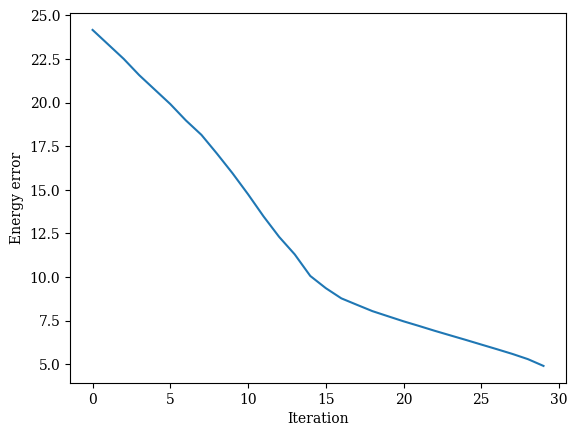

In [55]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [56]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Carry out SQD.

In [57]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [58]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 4, 'rx': 2, 'h': 2, 'barrier': 2, 'rz': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 8, 'rx': 4, 'h': 4, 'barrier': 3, 'rz': 2})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 12, 'rx': 6, 'h': 6, 'barrier': 4, 'rz': 3})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 16, 'x': 15, 'rx': 8, 'h': 8, 'barrier': 5, 'rz': 4})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 20, 'x': 15, 'rx': 10, 'h': 10, 'barrier': 6, 'rz': 5})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 24, 'x': 15, 'rx': 12, 'h': 12, 'barrier': 7, 'rz': 6})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 28, 'x': 15, 'rx': 14, 'h': 14, 'barrier': 8, 'rz': 7})
On circuit 7/30
Gate counts (w

In [59]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

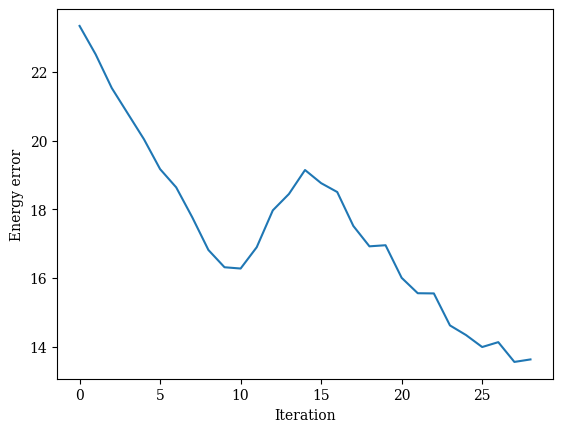

In [60]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [61]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

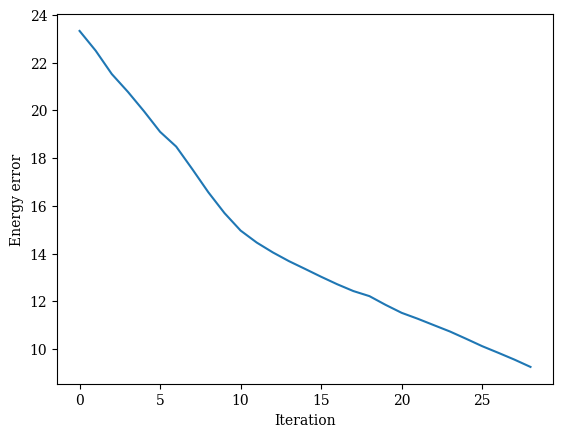

In [62]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

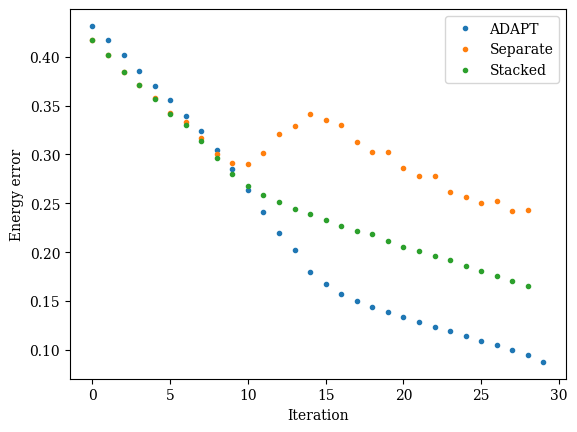

In [63]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()